# WorldFloods 2.0 
In this notebook we will show the data available in the WorldFloods data repository and how it is derived.
## Overview
In this notebook we will:
 1. Examine a specific flood event
 2. For a a given flood event process the 
     - area of interests
     - observed flood event
     - hydrography areas
     - hydrography lines
 3. Consolidate the data associated with a flood event to a floodmap and flood metadata
 4. Retrieve corresponding Sentinel-2 images
 5. Retrieve corresponding JRC Permanent water images
 6. Generate a water mask
 7. Generate a cloud mask

## 1 - Flood Events

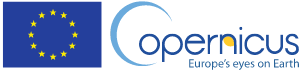

Copernicus Emergency Management Service (EMS) provides warnings and risk assessment of floods and other natural disasters through geospatial data derived from satellite imagery. It provides data before, during, and after events in Rapid Mapping format for emergencies and Risk and Recovery format for prevention. In WorldFloods we are primarily interested in the satellite derived imagery with a focus on fluvial, or river, floods.

### Copernicus EMS Rapid Activations

The Copernicus EMS Activation Mappings for individual events given by unique EMSR codes may be accessed [here](https://emergency.copernicus.eu/mapping/list-of-activations-rapid). Linked to each EMSR code per severe event in the Rapid Activations table is the individual webpage for the EMSR code featuring vector zip files from various sources. Each vector zip file may contain multiple products with respect to an event. For this notebook, we will walk through a single EMSR flood event from the alert code, to its associated url.

We may retrieve a pandas DataFrame format of the [EMS Rapid Activations](https://emergency.copernicus.eu/mapping/list-of-activations-rapid) table using the function <code>table_floods_ems</code> from the activations module in `ml4floods/src/data`. In this function you may specify how far back in time you would like to retrieve flood emergency mappings for. Be careful when choosing dates _prior to 23 June 2015_ when Sentinel-2 was launched into space.

In [1]:
from pyprojroot import here
import sys
import os
root = here(project_files=[".here"])
sys.path.append(str(here()))
from src.data.copernicusEMS import activations
from src.data import utils
from pathlib import Path

Let's take a look at the flood events that have occurred since the start of 2021.

In [2]:
table_activations_ems = activations.table_floods_ems(event_start_date="2021-01-01")
table_activations_ems

Title    CodeDate   Type  \
Code                                                                    
EMSR502                  Flood in Southern Ireland  2021-02-23  Flood   
EMSR501                           Flood in Albania  2021-01-06  Flood   
EMSR498        Flood in Corrèze department, France  2021-02-02  Flood   
EMSR497                           Flood in Germany  2021-02-01  Flood   
EMSR496               Flood in Lazio Region, Italy  2021-01-26  Flood   
EMSR495  Tropical cyclone Eloise in Mozambique,...  2021-01-22  Storm   
EMSR492                    Flood in Landes, France  2021-01-01  Flood   

                                Country  
Code                                     
EMSR502                         Ireland  
EMSR501                         Albania  
EMSR498                          France  
EMSR497                         Germany  
EMSR496                           Italy  
EMSR495  Mozambique, Eswatini, Zimbabwe  
EMSR492                          France

### EMSR 501: Flood in Shkodra, Albania
During heavy rains 4000 hectares of land was affected by flooding impacting 200 people. We take this event as an example to show how we retrieve and ingest data as an entry point to the preprocessed data used in the WorldFloods machine learning pipeline.

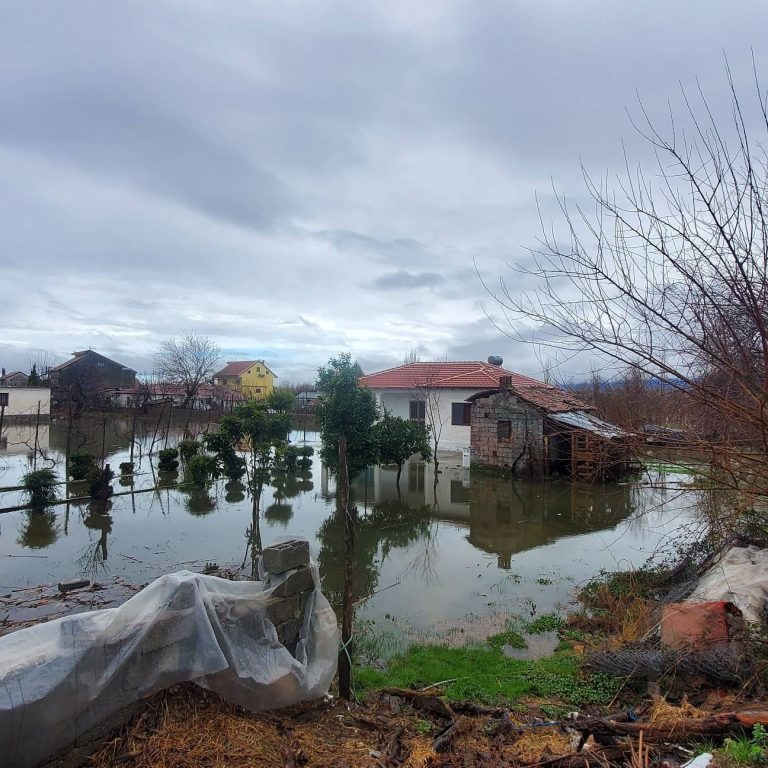

#### Retrieve the Zip File URLs for a given EMSR Code

The Copernicus EMS Activation Mapping URL location for the January 6th flood event in Shkodra, Albania can be fetched using the activation code "EMSR501" and the function <code>fetch_zip_files</code> from <code>activation.py</code> which outputs the url locations as a list of strings. Each of these zip file urls allow us to retrieve the vector shapefiles for different areas of interest within a single activation code.

In [3]:
emsr_code = "EMSR502"
zip_files_activation_url_list = activations.fetch_zip_file_urls(emsr_code)
zip_files_activation_url_list

['https://emergency.copernicus.eu/mapping/download/184779/EMSR502_AOI05_DEL_PRODUCT_r1_VECTORS_v2_vector.zip',
 'https://emergency.copernicus.eu/mapping/download/184772/EMSR502_AOI07_DEL_PRODUCT_r1_VECTORS_v2_vector.zip',
 'https://emergency.copernicus.eu/mapping/download/184759/EMSR502_AOI05_DEL_MONIT01_r1_VECTORS_v1_vector.zip',
 'https://emergency.copernicus.eu/mapping/download/184746/EMSR502_AOI04_DEL_MONIT01_r1_VECTORS_v1_vector.zip',
 'https://emergency.copernicus.eu/mapping/download/184743/EMSR502_AOI02_DEL_MONIT01_r1_VECTORS_v1_vector.zip',
 'https://emergency.copernicus.eu/mapping/download/184734/EMSR502_AOI03_DEL_MONIT01_r1_VECTORS_v1_vector.zip',
 'https://emergency.copernicus.eu/mapping/download/184733/EMSR502_AOI01_DEL_MONIT01_r1_VECTORS_v1_vector.zip',
 'https://emergency.copernicus.eu/mapping/download/184702/EMSR502_AOI04_DEL_PRODUCT_r1_VECTORS_v1_vector.zip',
 'https://emergency.copernicus.eu/mapping/download/184693/EMSR502_AOI03_DEL_PRODUCT_r1_VECTORS_v1_vector.zip',
 

Notice that this particular EMSR flood code has several area of interest (AOI) files. These files are present in the ml4cc_data_lake Google Cloud Storage bucket repository in their unzipped raw format as well as their zipped format. They can be found in the following locations:

- zipped files: gs://ml4cc_data_lake/0_DEV/0_Raw/WorldFloods/copernicus_ems/copernicus_ems_zip
- unzipped files: gs://ml4cc_data_lake/0_DEV/0_Raw/WorldFloods/copernicus_ems/copernicus_ems_unzip

#### Saving the Zip Files and Unzipping Locally

If you would like to save the zip files locally, you may do so by downloading them directly from _ml4cc_data_lake_ or by downloading the zip files directly from the Copernicus EMS rapid activations. Since this notebook goes over data ingestion from start to finish, we explain the process for both cases. To save the files locally we do the following: 

In [8]:
from tqdm import tqdm
folder_out = f"{root}/datasets/Copernicus_EMS_raw/{emsr_code}"
utils.create_folder(folder_out)

unzip_files_activation = []
for zip_file in tqdm(zip_files_activation_url_list):
    local_zip_file = activations.download_vector_cems(zip_file)
    unzipped_file = activations.unzip_copernicus_ems(local_zip_file,
                                                     folder_out=folder_out)
    unzip_files_activation.append(unzipped_file)

100%|██████████| 11/11 [00:00<00:00, 669.66it/s]

Folder '/home/ahmedn/projects/ml4floods/datasets/Copernicus_EMS_raw/EMSR502' Is Already There.
	File https://emergency.copernicus.eu/mapping/download/184779/EMSR502_AOI05_DEL_PRODUCT_r1_VECTORS_v2_vector.zip already exists. Not downloaded
	File https://emergency.copernicus.eu/mapping/download/184772/EMSR502_AOI07_DEL_PRODUCT_r1_VECTORS_v2_vector.zip already exists. Not downloaded
	File https://emergency.copernicus.eu/mapping/download/184759/EMSR502_AOI05_DEL_MONIT01_r1_VECTORS_v1_vector.zip already exists. Not downloaded
	File https://emergency.copernicus.eu/mapping/download/184746/EMSR502_AOI04_DEL_MONIT01_r1_VECTORS_v1_vector.zip already exists. Not downloaded
	File https://emergency.copernicus.eu/mapping/download/184743/EMSR502_AOI02_DEL_MONIT01_r1_VECTORS_v1_vector.zip already exists. Not downloaded
	File https://emergency.copernicus.eu/mapping/download/184734/EMSR502_AOI03_DEL_MONIT01_r1_VECTORS_v1_vector.zip already exists. Not downloaded
	File https://emergency.copernicus.eu/map

#### Uploading the Zip Files and Unzipping to Google Cloud Storage

When using Google Cloud Storage be sure to create an account with your gmail account of choice and look at the most recent documentation. One thing to be cautious about is the structure of the file system in storage. In Google Cloud, the files are flat, and directories are implied via filenames.

In [8]:
# File "directory" structure in the ml4cc_data_lake bucket
bucket_id = 'ml4cc_data_lake'
path_to_write_zip = '0_DEV/0_Raw/WorldFloods/copernicus_ems/copernicus_ems_zip'
path_to_write_unzip = '0_DEV/0_Raw/WorldFloods/copernicus_ems/copernicus_ems_unzip'

If you would would like to maintain the repository and add data to the public bucket, you would have to have Google Cloud Storage permissions. If you fall into this category, uploading new flood event EMSR codes and the associated zipped files would proceed as follows:

## 2 - Building EMSR Flood Metadata and Floodmaps

Following the scraping and downloading of Copernicus EMS Rapid Mapping Products in, we unzipped the files in our local file directory or to the Google Cloud Storage Bucket.

Once unzipped, multiple `.shp` files can be associated with a single EMSR Flood Activation Code. These files represent different activation layer data available as Copernicus EMS rapid mapping products. For more details with respect to each of the layers see below.

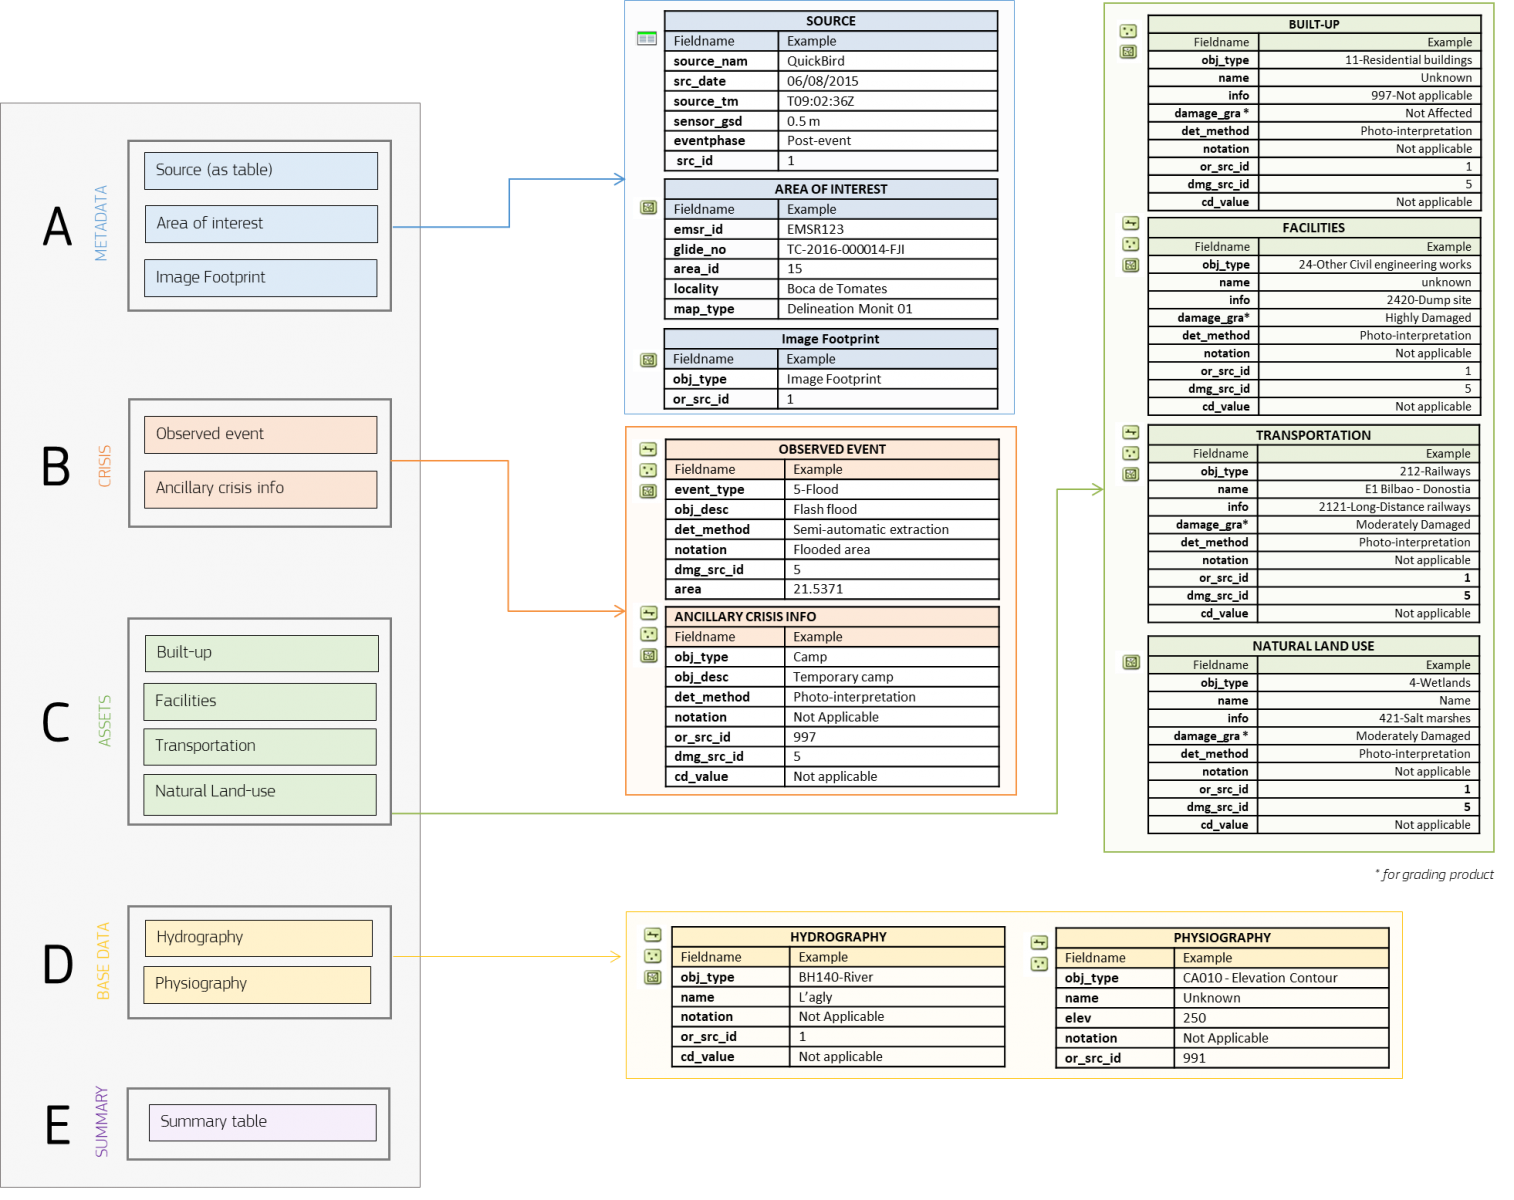

The layers of particular value to WorldFloods are the Metadata (A), Crisis (B), and Base Data (D) layers. More specifically, we are interested retrieving:

- A: Source and The Area of Interest (AOI)
- B: Observed Event data for Floods
- D: Hydrography areas and lines indicative of lakes and rivers 

With these data we can create a composite floodmask over an AOI. We will later obtain Sentinel-2 images associated with an AOI which we will overlay with a floodmap layer derived from A, B, and D Copernicus EMS products.

These shapefiles will be used to compose a floodmap for use in the generation of ground truth labels to be used in a supervised learning model pipeline.

### 2a - Process Shapefiles 

In function `filter_register_copernicusems` we check that all the `.shp` follow the expected conventions with respect to timestamp and data availability.

### 2b - Populate Copernicus EMSR Metadata Dictionary
`filter_register_copernicusems` upon extracting the source, AOI, observed event, and hydrography information, will populate a dictionary with keys associated with the source data and hold the filenames and paths of specific `.shp` files as values. 

### 2c - Generate Floodmap

We then process the `.shp` files area of interest, observed event, and the hydrography into a single `geopandas.GeoDataFrame` object using `generate_floodmap`. This information will be uploaded to the WorldFloods data bucket for new events.


In [10]:
# folder_out=f"Copernicus_EMS_raw/{activation}"
folder_out = f"{root}/datasets/Copernicus_EMS_raw/{emsr_code}"

code_date = table_activations_ems.loc[emsr_code]["CodeDate"]

registers = []
for unzip_folder in unzip_files_activation:
    metadata_floodmap = activations.filter_register_copernicusems(unzip_folder, code_date)
    if metadata_floodmap is not None:
        floodmap = activations.generate_floodmap(metadata_floodmap, folder_files=folder_out)
        registers.append({"metadata_floodmap": metadata_floodmap, "floodmap": floodmap})
        print(f"File {unzip_folder} processed correctly")
    else:
        print(f"File {unzip_folder} does not follow the expected format. It won't be processed")


File /home/ahmedn/projects/ml4floods/datasets/Copernicus_EMS_raw/EMSR502/EMSR502_AOI05_DEL_PRODUCT_r1_VECTORS_v2_vector processed correctly
File /home/ahmedn/projects/ml4floods/datasets/Copernicus_EMS_raw/EMSR502/EMSR502_AOI07_DEL_PRODUCT_r1_VECTORS_v2_vector processed correctly
File /home/ahmedn/projects/ml4floods/datasets/Copernicus_EMS_raw/EMSR502/EMSR502_AOI05_DEL_MONIT01_r1_VECTORS_v1_vector processed correctly
File /home/ahmedn/projects/ml4floods/datasets/Copernicus_EMS_raw/EMSR502/EMSR502_AOI04_DEL_MONIT01_r1_VECTORS_v1_vector processed correctly
File /home/ahmedn/projects/ml4floods/datasets/Copernicus_EMS_raw/EMSR502/EMSR502_AOI02_DEL_MONIT01_r1_VECTORS_v1_vector processed correctly
File /home/ahmedn/projects/ml4floods/datasets/Copernicus_EMS_raw/EMSR502/EMSR502_AOI03_DEL_MONIT01_r1_VECTORS_v1_vector processed correctly
File /home/ahmedn/projects/ml4floods/datasets/Copernicus_EMS_raw/EMSR502/EMSR502_AOI01_DEL_MONIT01_r1_VECTORS_v1_vector processed correctly
File /home/ahmedn/pr

In [13]:
metadata_floodmap

{'event id': 'EMSR502_AOI01_DEL_PRODUCT_r1_VECTORS_v1_vector',
 'layer name': 'EMSR502_AOI01_DEL_PRODUCT_observedEventA_r1_v1',
 'event type': 'Riverine flood',
 'satellite date': Timestamp('2021-02-23 18:23:26+0000', tz='UTC'),
 'country': 'NaN',
 'satellite': 'Sentinel-1',
 'bounding box': {'west': -7.94133200999994,
  'east': -7.492026624999937,
  'north': 52.40668061700006,
  'south': 52.26830817900003},
 'reference system': {'code space': 'epsg', 'code': '4326'},
 'abstract': 'NaN',
 'purpose': 'NaN',
 'source': 'CopernicusEMS',
 'area_of_interest_polygon': <shapely.geometry.polygon.Polygon at 0x7f7a38311e80>,
 'observed_event_file': 'EMSR502_AOI01_DEL_PRODUCT_observedEventA_r1_v1.shp',
 'area_of_interest_file': 'EMSR502_AOI01_DEL_PRODUCT_areaOfInterestA_r1_v1.shp',
 'ems_code': 'EMSR502',
 'satellite_pre_event': 'Open Street Map',
 'timestamp_pre_event': Timestamp('2021-02-23 00:00:00+0000', tz='UTC'),
 'hydrology_file': 'EMSR502_AOI01_DEL_PRODUCT_hydrographyA_r1_v1.shp',
 'hydro

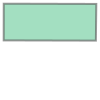

In [12]:
metadata_floodmap["area_of_interest_polygon"]

## 3 - Sentinel-2 and JRC Permanent Water Imagery Using Google Earth Engine

# Sentinel-2 Image Retrieval Using Google Earth Engine

To retrieve Sentinel-2 images from Google Earth Engine, make sure you create an account and authenticate prior to running the cell below. The link to sign up is [here](https://earthengine.google.com/new_signup/).



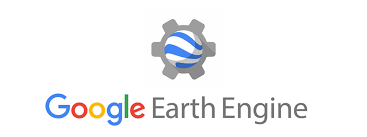

To download Sentinel-2 images we will be using the module <code>ee_download</code> and interact with the map using <code>geemap.eefolium</code>.

We use the AOI polygons retrieved from CopernicusEMS to select the location and time that we are interested in and use Google Earth Engine to do the georeferencing. Notice that we may also render the hydrography and observed flood event.

In [23]:
from datetime import timedelta
from datetime import datetime
import geopandas as gpd
import pandas as pd
import ee
import geemap.eefolium as geemap
import folium
from src.data import ee_download, create_gt

In [24]:
ee.Initialize()

bounds_pol = activations.generate_polygon(metadata_floodmap["area_of_interest_polygon"].bounds)
pol_2_clip = ee.Geometry.Polygon(bounds_pol)

# pol with the real area of interest
x, y = metadata_floodmap["area_of_interest_polygon"].exterior.coords.xy
pol_list = list(zip(x,y))
pol = ee.Geometry.Polygon(pol_list)

date_event = datetime.utcfromtimestamp(metadata_floodmap["satellite date"].timestamp())

date_end_search = date_event + timedelta(days=20)

img_col = ee_download.get_s2_collection(date_event, date_end_search, pol)
permanent_water_img= ee_download.download_permanent_water(date_event, pol_2_clip)


n_images_col = img_col.size().getInfo()
print(f"Found {n_images_col} S2 images between {date_event.isoformat()} and {date_end_search.isoformat()}")
Map = geemap.Map()

imgs_list = img_col.toList(n_images_col, 0)
for i in range(n_images_col):
    img_show = ee.Image(imgs_list.get(i))
    # print(img_show.bandNames().getInfo())
    Map.addLayer(img_show.clip(pol_2_clip), 
                 {"min":0, "max":3000, "bands":["B4","B3","B2"]},f"S2 {i}", True)
    Map.addLayer(permanent_water_img, name="permanent water")

geojson_geojson = "geojson_show.geojson"
geojson_filepath = f"{root}/datasets/Copernicus_EMS_raw/{geojson_geojson}"
floodmap.to_file(geojson_filepath, driver="GeoJSON")
Map.add_geojson(geojson_filepath, name="FloodMap")

Map.centerObject(pol)
folium.LayerControl(collapsed=False).add_to(Map)
# Map.addLayerControl()
Map

Found 6 S2 images between 2021-02-23T18:23:26 and 2021-03-15T18:23:26


## Export Sentinel-2 Images to the Google Cloud Bucket

Looking at the S2 images in the map, we see that the second image (S2.1) is the less cloudy of the three images retrieved by the Google Earth Engine. We will export that to the Google bucket to further inspect it. Use <code>task</code> to monitor the status. To run this part of the code you'd need access to the ml4floods Google bucket.

In [33]:
bucket_name= "ml4floods"

In [37]:
import os

BANDS_EXPORT = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B10', 'B11', 'B12', 'QA60', 'probability']

img_export = ee.Image(imgs_list.get(1))

img_export = img_export.select(BANDS_EXPORT).toFloat().clip(pol_2_clip) # .reproject(crs,scale=10).resample('bicubic') resample cannot be used on composites

# TODO in the future, change to export to drive and mount the Google drive in colab!

bucket_name= "ml4floods"

export_task_fun_img = ee_download.export_task_image(bucket=bucket_name)

filename = os.path.join("preingest", "S2", "albania")
desc = os.path.basename(filename) + "S2"
task = ee_download.mayberun(filename, desc,
                            lambda : img_export,
                            export_task_fun_img,
                            overwrite=False, dry_run=False,
                            bucket_name=bucket_name, verbose=2)
if task is not None:
    task.status()

sardinia## Retrieve Images from Bucket

To demonstrate that the images have been successfully uploaded to the Google Cloud Storage bucket, we open the image using <code>rasterio</code>. 

In [38]:
from src.data import create_gt
import rasterio

image_name = f"gs://{bucket_name}/{filename}.tif"
with rasterio.open(image_name) as src:
    print(src.shape)
    image = src.read()
    transform = src.transform

image.shape

RasterioIOError: '/vsigs/ml4floods/preingest/S2/albania.tif' does not exist in the file system, and is not recognized as a supported dataset name.

In [10]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16, 10)

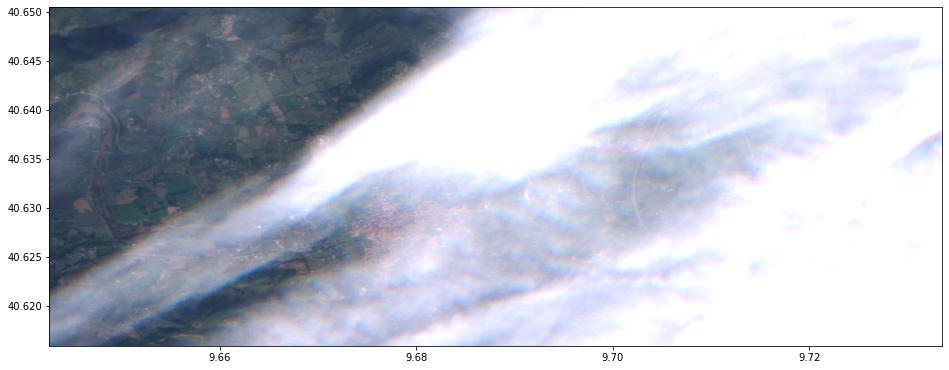

<AxesSubplot:>

In [11]:
from rasterio import plot as rasterioplt
import numpy as np

rgb = np.clip(image[(3,2,1),...]/3000.,0,1)
    
rasterioplt.show(rgb, transform=transform)

## 4 - GenerateGenerateGenerate Water Mask

In [26]:
water_mask = create_gt.compute_water(img_col, floodmap, keep_streams=True)

TypeError: invalid path or file: <ee.imagecollection.ImageCollection object at 0x7f7a30d6b5b0>

In [ ]:
rasterio_show(water_mask,vmin=-1, vmax=3)